In [121]:
# importing libaries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import os
import glob
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.neighbors import NearestNeighbors
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout


In [122]:


# Define file names and corresponding variable names
files = {
    "countryIndi": "Country_Indicators.csv",
    "country": "Country.csv",
    "economicIndi": "Economic_Indicators.csv",
    "enviroIndi": "Environmental_Indicators.csv",
    "qpsdIndi": "Public_Debt_Indicators_Agg.csv",
    "socialIndi": "Social_Indicators.csv",
    "statIndi": "Statistical_Indicators.csv",
    "yearIndi": "Year_Table.csv"
}

# Base path
base_path = '../WEEK 3/Indicators/'

# Read all files into a dictionary of DataFrames
data = {key: pd.read_csv(base_path + filename) for key, filename in files.items()}

# Access individual DataFrames like:
# data['countryIndi'], data['economicIndi'], etc.



In [123]:
data.keys()

dict_keys(['countryIndi', 'country', 'economicIndi', 'enviroIndi', 'qpsdIndi', 'socialIndi', 'statIndi', 'yearIndi'])

In [124]:
data['country'].head(3)

,Country Name,Country Code,Unnamed: 2,Unnamed: 3
0,Afghanistan,AFG,NaN,NaN
1,Albania,ALB,NaN,NaN
2,Algeria,DZA,NaN,NaN


In [125]:
data['country'].drop(columns=['Unnamed: 2', 'Unnamed: 3'], inplace=True)

In [126]:
# Fetch column shape from each DataFrame in the dictionary
for name, df in data.items():
    #print(name)
    #print(df)
    print(f"\nShape of '{name}': {df.shape[0]} rows, {df.shape[1]} columns")
    #print(df.shape.tolist())


Shape of 'countryIndi': 809 rows, 10 columns

Shape of 'country': 809 rows, 2 columns

Shape of 'economicIndi': 803 rows, 68 columns

Shape of 'enviroIndi': 803 rows, 11 columns

Shape of 'qpsdIndi': 318 rows, 67 columns

Shape of 'socialIndi': 803 rows, 75 columns

Shape of 'statIndi': 798 rows, 13 columns

Shape of 'yearIndi': 3 rows, 2 columns


In [127]:
# Fetch column names from each DataFrame in the dictionary
for name, df in data.items():
    print(f"\nColumns in '{name}':")
    print(df.columns.tolist())


Columns in 'countryIndi':
['Country Name', 'Country Code', 'Time', 'Time Code', 'Adjusted net national income (annual % growth) [NY.ADJ.NNTY.KD.ZG]', 'Adjusted net national income (constant 2015 US$) [NY.ADJ.NNTY.KD]', 'Adjusted net national income (current US$) [NY.ADJ.NNTY.CD]', 'Adjusted net national income per capita (annual % growth) [NY.ADJ.NNTY.PC.KD.ZG]', 'Adjusted net national income per capita (constant 2015 US$) [NY.ADJ.NNTY.PC.KD]', 'Adjusted net national income per capita (current US$) [NY.ADJ.NNTY.PC.CD]']

Columns in 'country':
['Country Name', 'Country Code']

Columns in 'economicIndi':
['Country Name', 'Country Code', 'Time', 'Time Code', 'Adjusted net national income (annual % growth) [NY.ADJ.NNTY.KD.ZG]', 'Adjusted net national income (constant 2015 US$) [NY.ADJ.NNTY.KD]', 'Adjusted net national income (current US$) [NY.ADJ.NNTY.CD]', 'Current account balance (% of GDP) [BN.CAB.XOKA.GD.ZS]', 'Current account balance (BoP, current US$) [BN.CAB.XOKA.CD]', 'Exports of 

In [128]:
import pandas as pd

# Step 1: Convert merge keys to the same type
for df_name in ['countryIndi', 'economicIndi', 'enviroIndi', 'qpsdIndi', 'socialIndi', 'statIndi', 'yearIndi']:
    for col in ['Country Code', 'Time', 'Time Code']:
        if col in data[df_name].columns:
            data[df_name][col] = data[df_name][col].astype(str)

# Step 2: Start merging one by one
merged_df = data['countryIndi']

# Define list of other datasets to merge (excluding 'countryIndi' which is already used)
to_merge = ['economicIndi', 'enviroIndi', 'qpsdIndi', 'socialIndi', 'statIndi']

# Step 3: Merge all indicator datasets on 'Country Code' and 'Time'
for key in to_merge:
    merged_df = pd.merge(merged_df, data[key], on=['Country Code', 'Time'], how='outer', suffixes=('', f'_{key}'))

# Step 4: Merge the year table (to bring in Time Code if needed)
if 'Time Code' not in merged_df.columns:
    merged_df = pd.merge(merged_df, data['yearIndi'], on='Time', how='left')

# Optional: Merge country table to enrich with names if needed
#merged_df = pd.merge(merged_df, data['country'], on='Country Code', how='left', suffixes=('', '_country'))

# Step 5: Drop duplicate columns if any (like multiple 'Country Name' columns)
merged_df = merged_df.loc[:, ~merged_df.columns.duplicated()]


In [129]:
merged_df.head(5)

,Country Name,Country Code,Time,Time Code,Adjusted net national income (annual % growth) [NY.ADJ.NNTY.KD.ZG],Adjusted net national income (constant 2015 US$) [NY.ADJ.NNTY.KD],Adjusted net national income (current US$) [NY.ADJ.NNTY.CD],Adjusted net national income per capita (annual % growth) [NY.ADJ.NNTY.PC.KD.ZG],Adjusted net national income per capita (constant 2015 US$) [NY.ADJ.NNTY.PC.KD],Adjusted net national income per capita (current US$) [NY.ADJ.NNTY.PC.CD],...,Time Code_statIndi,Broad_Money_Perc,Broad_Money_Total,Broad_Money_Growth,Broad_Money_Reserves,Exchange_Rate,Total_Reserves_Perc,Total_Reserves_Gold,Total_Reserves_Months_Imports,Total_Reserves_Without_Gold
0,NaN,ABW,2021,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,YR2021,102.3226044,5365500000,11.84183099,1.981206032,1.79,..,1512960280,8.608908926,1330950280
1,Aruba,ABW,2021.0,YR2021,..,..,2662868130,..,..,24724.86657,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,ABW,2022,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,YR2022,94.44252884,5543800000,3.323082658,2.005967712,1.79,..,1543940590,6.978284418,1362705590
3,Aruba,ABW,2022.0,YR2022,..,..,..,..,..,..,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,ABW,2023,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,YR2023,85.55422252,5587500000,0.788267975,2.126148351,1.79,..,1468151730,..,1261911730


In [130]:
merged_df.columns.to_list()

['Country Name',
 'Country Code',
 'Time',
 'Time Code',
 'Adjusted net national income (annual % growth) [NY.ADJ.NNTY.KD.ZG]',
 'Adjusted net national income (constant 2015 US$) [NY.ADJ.NNTY.KD]',
 'Adjusted net national income (current US$) [NY.ADJ.NNTY.CD]',
 'Adjusted net national income per capita (annual % growth) [NY.ADJ.NNTY.PC.KD.ZG]',
 'Adjusted net national income per capita (constant 2015 US$) [NY.ADJ.NNTY.PC.KD]',
 'Adjusted net national income per capita (current US$) [NY.ADJ.NNTY.PC.CD]',
 'Country Name_economicIndi',
 'Time Code_economicIndi',
 'Adjusted net national income (annual % growth) [NY.ADJ.NNTY.KD.ZG]_economicIndi',
 'Adjusted net national income (constant 2015 US$) [NY.ADJ.NNTY.KD]_economicIndi',
 'Adjusted net national income (current US$) [NY.ADJ.NNTY.CD]_economicIndi',
 'Current account balance (% of GDP) [BN.CAB.XOKA.GD.ZS]',
 'Current account balance (BoP, current US$) [BN.CAB.XOKA.CD]',
 'Exports of goods and services (% of GDP) [NE.EXP.GNFS.ZS]',
 'Exp

In [131]:
merged_df.describe()

,"Gross PSD, Budgetary Central Gov., All maturities, All instruments, Domestic creditors, Nominal Value, % of GDP [DP.DOD.DECD.CR.BC.Z1]","Gross PSD, Budgetary Central Gov., All maturities, All instruments, Nominal Value, US$ [DP.DOD.DECT.CR.BC.CD]","Gross PSD, Budgetary Central Gov., Long-term, All instruments, Nominal Value, US$ [DP.DOD.DLTC.CR.BC.CD]","Gross PSD, Budgetary Central Gov., Short-term, All instruments, Nominal Value, US$ [DP.DOD.DSTC.CR.BC.CD]","Gross PSD, Budgetary Central Gov., All maturities, All instruments, External creditors, Nominal Value, National Currency [DP.DOD.DECX.CR.BC]","Gross PSD, Budgetary Central Gov., All maturities, All instruments, External creditors, Nominal Value, US$ [DP.DOD.DECX.CR.BC.CD]","Gross PSD, Budgetary Central Gov., All maturities, All instruments, External creditors, Nominal Value, % of GDP [DP.DOD.DECX.CR.BC.Z1]","Gross PSD, Budgetary Central Gov., All maturities, All instruments, Foreign currency, Nominal Value, % of GDP [DP.DOD.DECF.CR.BC.Z1]","Gross PSD, Budgetary Central Gov., All maturities, All instruments, Foreign currency, Nominal Value, National Currency [DP.DOD.DECF.CR.BC]","Gross PSD, Budgetary Central Gov., All maturities, All instruments, Foreign currency, Nominal Value, US$ [DP.DOD.DECF.CR.BC.CD]",...,"Gross PSD, Nonfinancial Public Corp., All maturities, All instruments, Nominal Value, % of GDP [DP.DOD.DECT.CR.NF.Z1]","Gross PSD, Nonfinancial Public Corp., All maturities, All instruments, Nominal Value, National Currency [DP.DOD.DECT.CR.NF]","Gross PSD, Nonfinancial Public Corp., All maturities, All instruments, Nominal Value, US$ [DP.DOD.DECT.CR.NF.CD]","Gross PSD, Nonfinancial Public Corp., All maturities, Debt Securities, Market value, % of GDP [DP.DOD.DLDS.CR.MV.NF.Z1]","Gross PSD, Public Sector, All maturities, All instruments, External creditors, Nominal Value, National Currency [DP.DOD.DECX.CR.PS]","Gross PSD, Public Sector, All maturities, All instruments, Foreign currency, Nominal Value, National Currency [DP.DOD.DECF.CR.PS]","Gross PSD, Public Sector, All maturities, All instruments, Nominal Value, National Currency [DP.DOD.DECT.CR.PS]","Gross PSD, Total, All maturities, All instruments, External creditors, Nominal Value, US$ [DP.DOD.DECX.CR.PS.CD]","Gross PSD, Total, All maturities, All instruments, Foreign currency, Nominal Value, US$ [DP.DOD.DECF.CR.PS.CD]","Gross PSD, Total, All maturities, All instruments, Nominal Value, US$ [DP.DOD.DECT.CR.PS.CD]"
count,318.000000,3.180000e+02,3.180000e+02,3.180000e+02,3.180000e+02,3.180000e+02,318.000000,318.000000,3.180000e+02,3.180000e+02,...,318.000000,3.180000e+02,3.180000e+02,318.000000,3.180000e+02,3.180000e+02,3.180000e+02,3.180000e+02,3.180000e+02,3.180000e+02
mean,35.365510,4.062761e+11,3.620581e+11,2.697665e+10,1.174957e+14,1.144941e+11,26.429587,18.494102,1.008669e+14,2.953812e+10,...,7.655272,5.271548e+13,7.001719e+10,2.602514,1.506543e+14,1.684935e+14,5.829074e+14,8.003859e+10,3.815457e+10,5.626244e+11
std,74.801817,1.980177e+12,1.754286e+12,1.015822e+11,1.129674e+15,4.610096e+11,49.944061,42.432552,8.499459e+14,8.402731e+10,...,34.655231,4.185356e+14,3.339776e+11,24.131861,1.494058e+15,1.540385e+15,5.460382e+15,3.261728e+11,1.444102e+11,2.801419e+12
min,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00,...,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00,...,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00,...,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,44.560170,6.54

In [132]:
merged_df.shape

(2971, 234)

### Predict: Will rapid economic growth cause environmental degradation?

In [133]:
# Creating new dataframe with only the columns we want to predict
#  Step 1: Define the list of columns you want
predictive_columns = [
    'Country Name',
    'Time',
    'GDP growth (annual %) [NY.GDP.MKTP.KD.ZG]',
    'Carbon dioxide (CO2) emissions (total) excluding LULUCF (% change from 1990) [EN.GHG.CO2.ZG.AR5]',
    'Foreign direct investment, net inflows (% of GDP) [BX.KLT.DINV.WD.GD.ZS]',
    'Gross domestic savings (% of GDP) [NY.GDS.TOTL.ZS]',
    'Forest area (sq. km) [AG.LND.FRST.K2]',
    'General government final consumption expenditure (% of GDP) [NE.CON.GOVT.ZS]',
    'Exports of goods and services (% of GDP) [NE.EXP.GNFS.ZS]',
    'Imports of goods and services (% of GDP) [NE.IMP.GNFS.ZS]',
    'Access to electricity, rural (% of rural population) [EG.ELC.ACCS.RU.ZS]',
    'Access to electricity, urban (% of urban population) [EG.ELC.ACCS.UR.ZS]',
    'Renewable energy consumption (% of total final energy consumption) [EG.FEC.RNEW.ZS]',
    'Carbon dioxide (CO2) emissions excluding LULUCF per capita (t CO2e/capita) [EN.GHG.CO2.PC.CE.AR5]',
    'Adjusted net national income (annual % growth) [NY.ADJ.NNTY.KD.ZG]',
    'Adjusted net national income per capita (annual % growth) [NY.ADJ.NNTY.PC.KD.ZG]'
]

# Step 2: Create the new DataFrame
df = merged_df[predictive_columns].copy()


In [134]:
df['Time'] = pd.to_numeric(df['Time'], errors='coerce').astype('Int64')

In [135]:
df.head(5)

,Country Name,Time,GDP growth (annual %) [NY.GDP.MKTP.KD.ZG],Carbon dioxide (CO2) emissions (total) excluding LULUCF (% change from 1990) [EN.GHG.CO2.ZG.AR5],"Foreign direct investment, net inflows (% of GDP) [BX.KLT.DINV.WD.GD.ZS]",Gross domestic savings (% of GDP) [NY.GDS.TOTL.ZS],Forest area (sq. km) [AG.LND.FRST.K2],General government final consumption expenditure (% of GDP) [NE.CON.GOVT.ZS],Exports of goods and services (% of GDP) [NE.EXP.GNFS.ZS],Imports of goods and services (% of GDP) [NE.IMP.GNFS.ZS],"Access to electricity, rural (% of rural population) [EG.ELC.ACCS.RU.ZS]","Access to electricity, urban (% of urban population) [EG.ELC.ACCS.UR.ZS]",Renewable energy consumption (% of total final energy consumption) [EG.FEC.RNEW.ZS],Carbon dioxide (CO2) emissions excluding LULUCF per capita (t CO2e/capita) [EN.GHG.CO2.PC.CE.AR5],Adjusted net national income (annual % growth) [NY.ADJ.NNTY.KD.ZG],Adjusted net national income per capita (annual % growth) [NY.ADJ.NNTY.PC.KD.ZG]
0,NaN,2021,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Aruba,2021,24.13262736,149.1786959,4.55871502,16.2526902,4.2,22.83170585,70.74004287,76.27553323,100,100,8.8,4.648096565,..,..
2,NaN,2022,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Aruba,2022,8.517918105,150.223992,7.567071864,23.17391095,4.2,21.20776441,87.57027983,85.31389125,100,100,8.8,4.684558755,..,..
4,NaN,2023,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [136]:
df.shape

(2971, 16)

In [137]:
df.isna().sum()

Country Name                                                                                         2173
Time                                                                                                 1375
GDP growth (annual %) [NY.GDP.MKTP.KD.ZG]                                                            2173
Carbon dioxide (CO2) emissions (total) excluding LULUCF (% change from 1990) [EN.GHG.CO2.ZG.AR5]     2173
Foreign direct investment, net inflows (% of GDP) [BX.KLT.DINV.WD.GD.ZS]                             2173
Gross domestic savings (% of GDP) [NY.GDS.TOTL.ZS]                                                   2173
Forest area (sq. km) [AG.LND.FRST.K2]                                                                2173
General government final consumption expenditure (% of GDP) [NE.CON.GOVT.ZS]                         2173
Exports of goods and services (% of GDP) [NE.EXP.GNFS.ZS]                                            2173
Imports of goods and services (% of GDP) [NE.I

In [138]:
df = df[df['Country Name'].notna()]


In [139]:
# Rename two key columns for ease of use
df = df.rename(columns={
    'GDP growth (annual %) [NY.GDP.MKTP.KD.ZG]': 'GDP_growth',
    'Carbon dioxide (CO2) emissions (total) excluding LULUCF (% change from 1990) [EN.GHG.CO2.ZG.AR5]': 'CO2_change'
})

In [140]:
# Safely convert to float
df['GDP_growth'] = pd.to_numeric(df['GDP_growth'], errors='coerce')
df['CO2_change'] = pd.to_numeric(df['CO2_change'], errors='coerce')

# Then drop rows where conversion failed
df = df.dropna(subset=['GDP_growth', 'CO2_change']).reset_index(drop=True)

In [141]:
non_numeric = df[["GDP_growth", "CO2_change"]].apply(pd.to_numeric, errors='coerce')
invalid_rows = df[non_numeric.isna().any(axis=1)]
print(f"Number of rows with invalid numeric values: {invalid_rows.shape[0]}")


Number of rows with invalid numeric values: 0


In [142]:
df = df.drop(index=invalid_rows.index).reset_index(drop=True)

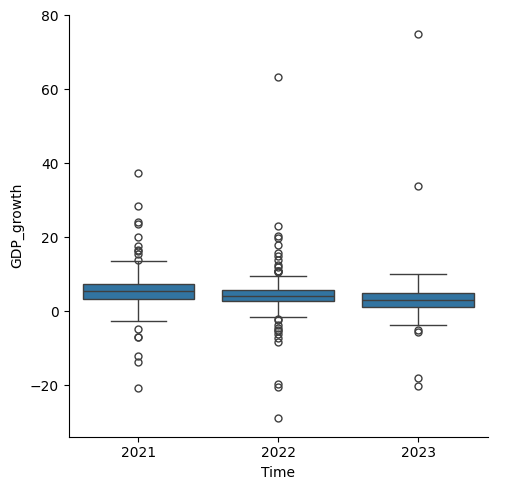

In [143]:
#create the box plot
sns.catplot(data= df, x='Time',
            y='GDP_growth',kind='box')

In [146]:
df.shape

(661, 16)

In [147]:
df.isna().sum()

Country Name                                                                                         0
Time                                                                                                 0
GDP_growth                                                                                           0
CO2_change                                                                                           0
Foreign direct investment, net inflows (% of GDP) [BX.KLT.DINV.WD.GD.ZS]                             0
Gross domestic savings (% of GDP) [NY.GDS.TOTL.ZS]                                                   0
Forest area (sq. km) [AG.LND.FRST.K2]                                                                0
General government final consumption expenditure (% of GDP) [NE.CON.GOVT.ZS]                         0
Exports of goods and services (% of GDP) [NE.EXP.GNFS.ZS]                                            0
Imports of goods and services (% of GDP) [NE.IMP.GNFS.ZS]                

In [148]:
df.tail(5)

,Country Name,Time,GDP_growth,CO2_change,"Foreign direct investment, net inflows (% of GDP) [BX.KLT.DINV.WD.GD.ZS]",Gross domestic savings (% of GDP) [NY.GDS.TOTL.ZS],Forest area (sq. km) [AG.LND.FRST.K2],General government final consumption expenditure (% of GDP) [NE.CON.GOVT.ZS],Exports of goods and services (% of GDP) [NE.EXP.GNFS.ZS],Imports of goods and services (% of GDP) [NE.IMP.GNFS.ZS],"Access to electricity, rural (% of rural population) [EG.ELC.ACCS.RU.ZS]","Access to electricity, urban (% of urban population) [EG.ELC.ACCS.UR.ZS]",Renewable energy consumption (% of total final energy consumption) [EG.FEC.RNEW.ZS],Carbon dioxide (CO2) emissions excluding LULUCF per capita (t CO2e/capita) [EN.GHG.CO2.PC.CE.AR5],Adjusted net national income (annual % growth) [NY.ADJ.NNTY.KD.ZG],Adjusted net national income per capita (annual % growth) [NY.ADJ.NNTY.PC.KD.ZG]
656,Zambia,2022,5.211224,157.826948,-0.223286755,49.96630807,444376.011,14.45282902,40.19399771,29.10331771,14.5,87,..,0.387387685,..,..
657,Zambia,2023,5.367943,166.149273,0.311507238,39.58210699,..,13.31278271,40.84612397,37.39576308,..,..,..,0.388873461,..,..
658,Zimbabwe,2021,8.468017,-38.977063,0.871791032,10.21041094,173985.1,14.91590377,22.77524072,28.07188765,31.6,85.3,82.4,0.672479507,38.97510643,36.59696316
659,Zimbabwe,2022,6.139263,-37.025740,1.027031259,5.591071807,173524.4,16.64619081,27.87217069,36.89143744,33.7,89,..,0.682242939,..,..
660,Zimbabwe,2023,5.336730,-32.538903,1.583455408,8.637876657,..,15.08923343,21.57940038,29.21556351,..,..,..,0.718697015,..,..


In [149]:
df.describe()

,Time,GDP_growth,CO2_change
count,661.0,661.000000,661.000000
mean,2021.912254,4.484656,563.182509
std,0.794785,6.189584,3433.749294
min,2021.0,-28.758584,-82.661980
25%,2021.0,2.402481,-1.428727
50%,2022.0,4.159986,133.699426
75%,2023.0,6.217851,274.997707
max,2023.0,75.061377,49754.545450


In [150]:
df.shape

(661, 16)

In [152]:
# Convert all object columns to numeric (coerce errors to NaN)
numeric_df = df.drop(columns=['Country Name'])
for col in numeric_df.select_dtypes(include='object').columns:
    numeric_df[col] = pd.to_numeric(numeric_df[col], errors='coerce')

In [155]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb

# Define target labels
def label_environmental_degradation(row):
    if row['GDP_growth'] > 2 and row['CO2_change'] > 2:
        return 'High Degradation'
    elif row['GDP_growth'] > 2 and row['CO2_change'] <= 0:
        return 'Green Growth'
    else:
        return 'Neutral'

numeric_df['Degradation_Label'] = numeric_df.apply(label_environmental_degradation, axis=1)

# Encode target variable
le = LabelEncoder()
numeric_df['Target'] = le.fit_transform(numeric_df['Degradation_Label'])

# removing categorical columns
#df.drop(columns=['Country Name', 'Time'], inplace=True)
# Train/test split
feature_cols = numeric_df.columns.difference(['Degradation_Label', 'Target'])
X = numeric_df[feature_cols]
y = numeric_df['Target']

# Clean feature names: remove or replace invalid characters
X.columns = X.columns.str.replace(r'[\[\]<>]', '', regex=True)

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# Create and train XGBoost model
xgb_clf = xgb.XGBClassifier(
    objective='multi:softmax',  # for multi-class classification
    num_class=len(df['Target'].unique()),  # number of classes
    max_depth=4,
    learning_rate=0.1,
    n_estimators=100,
    use_label_encoder=False,
    eval_metric='mlogloss',
    random_state=42,
    enable_categorical=True
)
xgb_clf.fit(X_train, y_train)

# Predict and evaluate
y_pred = xgb_clf.predict(X_test)

print("=== Accuracy Score ===")
print(f"{accuracy_score(y_test, y_pred):.3f}\n")

print("=== Confusion Matrix ===")
print(confusion_matrix(y_test, y_pred), "\n")

print("=== Classification Report ===")
print(classification_report(y_test, y_pred))


=== Accuracy Score ===
0.995

=== Confusion Matrix ===
[[ 36   0   0]
 [  0 118   0]
 [  0   1  44]] 

=== Classification Report ===
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        36
           1       0.99      1.00      1.00       118
           2       1.00      0.98      0.99        45

    accuracy                           0.99       199
   macro avg       1.00      0.99      0.99       199
weighted avg       1.00      0.99      0.99       199



c:\Users\kanak\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:28:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


C:\Users\kanak\AppData\Local\Temp\ipykernel_16744\2080075905.py:13: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


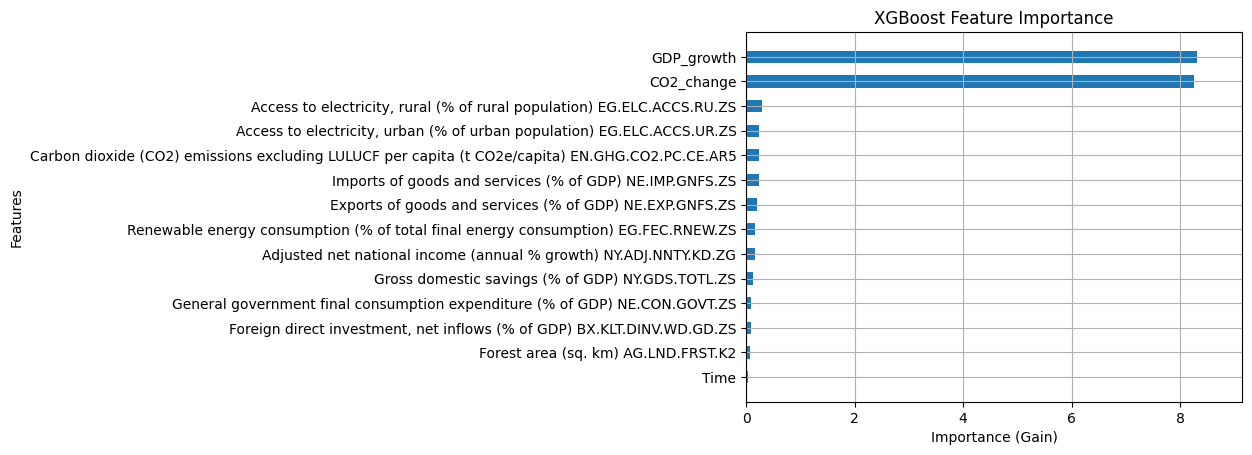

In [156]:
import matplotlib.pyplot as plt
import xgboost as xgb

# Optional: use cleaned feature names if you renamed them earlier
xgb.plot_importance(xgb_clf, 
                    importance_type='gain',  # or 'weight', 'cover'
                    max_num_features=20,     # top 20 features
                    height=0.5, 
                    title="XGBoost Feature Importance",
                    xlabel="Importance (Gain)",
                    show_values=False)

plt.tight_layout()
plt.show()


#### analyze country-level insights from your clustered data.

In [60]:
# Subset of essential columns
cols_needed = [
    'Country Name',
   'GDP growth (annual %) [NY.GDP.MKTP.KD.ZG]',
    'Carbon dioxide (CO2) emissions (total) excluding LULUCF (% change from 1990) [EN.GHG.CO2.ZG.AR5]',
    'Renewable energy consumption (% of total final energy consumption) [EG.FEC.RNEW.ZS]'
]

# Drop rows with missing values in key columns
df_filtered = merged_df.dropna(subset=cols_needed)
print(f"Usable rows for classification: {df_filtered.shape[0]}")


Usable rows for classification: 798


In [61]:
# List of columns to exclude
exclude_cols = ['Country Name', 'Country Code', 'Time']

# Loop through all other columns and convert to numeric
for col in df_filtered.columns:
    if col not in exclude_cols:
        df_filtered[col] = pd.to_numeric(df_filtered[col], errors='coerce')


C:\Users\kanak\AppData\Local\Temp\ipykernel_40888\3543008894.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered[col] = pd.to_numeric(df_filtered[col], errors='coerce')


In [64]:
df_filtered['Time'] = df_filtered['Time'].astype('Float64')  # Nullable integer type


C:\Users\kanak\AppData\Local\Temp\ipykernel_40888\3471657670.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['Time'] = df_filtered['Time'].astype('Float64')  # Nullable integer type


In [65]:
print(df_filtered.shape)
# checking for null values
missing_values_count = df_filtered.isnull().sum()
missing_values_count

(798, 234)


Country Name                                                            0
Country Code                                                            0
Time                                                                    0
Time Code                                                             798
Adjusted net national income (annual % growth) [NY.ADJ.NNTY.KD.ZG]    623
                                                                     ... 
Exchange_Rate                                                         798
Total_Reserves_Perc                                                   798
Total_Reserves_Gold                                                   798
Total_Reserves_Months_Imports                                         798
Total_Reserves_Without_Gold                                           798
Length: 234, dtype: int64

In [69]:
df_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Index: 798 entries, 1 to 1595
Columns: 234 entries, Country Name to Total_Reserves_Without_Gold
dtypes: Float64(1), float64(231), object(2)
memory usage: 1.4+ MB


In [ ]:
# let try using cluster analysis 
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# Step 1: Select relevant columns
features = df_filtered[[
    'GDP growth (annual %) [NY.GDP.MKTP.KD.ZG]',
    'Carbon dioxide (CO2) emissions (total) excluding LULUCF (% change from 1990) [EN.GHG.CO2.ZG.AR5]',
    'Renewable energy consumption (% of total final energy consumption) [EG.FEC.RNEW.ZS]'
]].dropna()  # Drop rows with missing data

# Step 2: Scale the features (important for KMeans)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(features)


# Step 3: Run KMeans with 3 clusters (High, Moderate, Low Impact)
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(X_scaled)

# Step 4: Add cluster labels back to the original dataframe
features['Impact_Cluster'] = clusters


# Step 5: Interpret and label clusters
# You might want to look at group means to rename clusters meaningfully
cluster_means = features.groupby('Impact_Cluster').mean()
cluster_means

cluster_map = {
    0: 'High Impact',
    1: 'Moderate Impact',
    2: 'Low Impact'
}
features['Impact_Label'] = features['Impact_Cluster'].map(cluster_map)



In [71]:
# Merge Impact_Label from clustering back to main df
df_clustered = df_filtered.merge(
    features[['Impact_Label']],
    left_index=True,
    right_index=True,
    how='left'
)

# Show example countries from each cluster
df_clustered[['Country Name', 'Time', 'Impact_Label']].drop_duplicates().groupby('Impact_Label').head(5)

df_clustered.groupby('Impact_Label')[[
    'GDP growth (annual %) [NY.GDP.MKTP.KD.ZG]',
    'Carbon dioxide (CO2) emissions (total) excluding LULUCF (% change from 1990) [EN.GHG.CO2.ZG.AR5]',
    'Renewable energy consumption (% of total final energy consumption) [EG.FEC.RNEW.ZS]'
]].mean().round(2)


,GDP growth (annual %) [NY.GDP.MKTP.KD.ZG],Carbon dioxide (CO2) emissions (total) excluding LULUCF (% change from 1990) [EN.GHG.CO2.ZG.AR5],Renewable energy consumption (% of total final energy consumption) [EG.FEC.RNEW.ZS]
Impact_Label,,,
High Impact,6.66,273.70,13.98
Low Impact,-4.64,43535.83,11.70
Moderate Impact,3.21,673.98,67.55


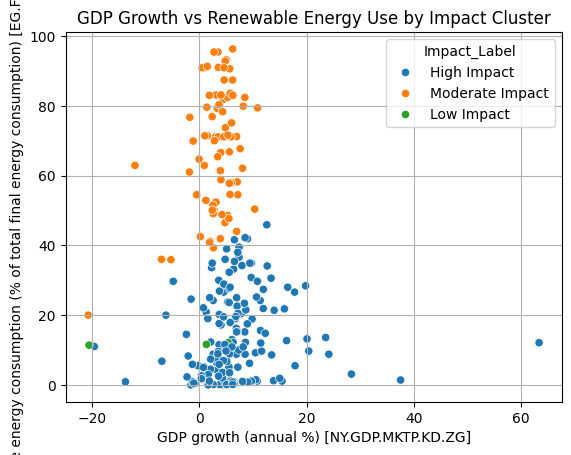

In [72]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.scatterplot(
    data=df_clustered,
    x='GDP growth (annual %) [NY.GDP.MKTP.KD.ZG]',
    y='Renewable energy consumption (% of total final energy consumption) [EG.FEC.RNEW.ZS]',
    hue='Impact_Label'
)
plt.title("GDP Growth vs Renewable Energy Use by Impact Cluster")
plt.grid(True)
plt.show()


In [73]:
df_clustered.head(8)

,Country Name,Country Code,Time,Time Code,Adjusted net national income (annual % growth) [NY.ADJ.NNTY.KD.ZG],Adjusted net national income (constant 2015 US$) [NY.ADJ.NNTY.KD],Adjusted net national income (current US$) [NY.ADJ.NNTY.CD],Adjusted net national income per capita (annual % growth) [NY.ADJ.NNTY.PC.KD.ZG],Adjusted net national income per capita (constant 2015 US$) [NY.ADJ.NNTY.PC.KD],Adjusted net national income per capita (current US$) [NY.ADJ.NNTY.PC.CD],...,Broad_Money_Perc,Broad_Money_Total,Broad_Money_Growth,Broad_Money_Reserves,Exchange_Rate,Total_Reserves_Perc,Total_Reserves_Gold,Total_Reserves_Months_Imports,Total_Reserves_Without_Gold,Impact_Label
1,Aruba,ABW,2021.0,NaN,NaN,NaN,2.662868e+09,NaN,NaN,24724.866570,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,High Impact
3,Aruba,ABW,2022.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,High Impact
5,Aruba,ABW,2023.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,Africa Eastern and Southern,AFE,2021.0,NaN,5.373146,8.969740e+11,8.663150e+11,2.618008,1257.867757,1214.873282,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,Africa Eastern and Southern,AFE,2022.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11,Africa Eastern and Southern,AFE,2023.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13,Afghanistan,AFG,2021.0,NaN,-19.505733,NaN,1.362107e+10,-21.380090,NaN,340.523244,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Moderate Impact
15,Afghanistan,AFG,2022.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,High Impact


###
🔹 Q1: Are high-growth countries investing in renewables or ignoring them?
Answer:
High-growth countries (clustered in the High Impact group) are largely ignoring renewables.
Despite strong GDP growth (often >10%), these countries show low renewable energy adoption, typically below 20%.
This suggests a growth model still dependent on fossil fuels, contributing to environmental degradation.

🔹 Q2: Do low-impact countries have higher renewable energy adoption?
Answer:
Yes, significantly.
Low-impact countries (shown in blue) exhibit very high renewable energy use — often above 60% — and moderate or low GDP growth.
These countries are likely balancing economic activity with strong environmental policies and clean energy investments, leading to their low impact classification.

🔹 Q3: Is moderate impact a transition zone?
Answer:
Yes — the Moderate Impact cluster appears to represent a transitional group.
These countries have moderate renewable energy use (10–40%) and low to mid GDP growth.
They might be in the process of increasing clean energy usage or adjusting their growth models, moving either toward sustainability or unsustainability depending on their future trajectory.



#####
LETS TRY TO ANS FIRST : Classify countries into "Investing" or "Ignoring" renewables using GDP growth as the input.

In [74]:
#Step 1: Create a Label — “Renewable_Label”
# Label countries as Investing vs Ignoring based on renewable energy threshold (30% is a common mark)
df_clustered['Renewable_Label'] = df_clustered[
    'Renewable energy consumption (% of total final energy consumption) [EG.FEC.RNEW.ZS]'
].apply(lambda x: 'Investing' if x >= 30 else 'Ignoring')

In [75]:
# Step 2: Prepare the Features and Labels
from sklearn.model_selection import train_test_split

# Select features and labels
X = df_clustered[['GDP growth (annual %) [NY.GDP.MKTP.KD.ZG]']].dropna()
y = df_clustered.loc[X.index, 'Renewable_Label']


In [76]:
#Assumption 1 If the model accurately predicts "Investing" based on GDP, 
# then GDP growth influences renewable adoption.

#Assumption 2 : If most high-GDP-growth countries are predicted as "Ignoring", 
# it confirms that economic growth does not align with renewable investment.

from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

# Train model
#clf = DecisionTreeClassifier(max_depth=3, random_state=42,class_weight='balanced')
clf = DecisionTreeClassifier(max_depth=3, random_state=42)
clf.fit(X_train, y_train)

# Predict
y_pred = clf.predict(X_test)

# Evaluate
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

    Ignoring       0.87      1.00      0.93       164
   Investing       0.00      0.00      0.00        25

    accuracy                           0.87       189
   macro avg       0.43      0.50      0.46       189
weighted avg       0.75      0.87      0.81       189



c:\Users\kanak\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\kanak\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\kanak\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

Assumption 1:
If the model accurately predicts "Investing" based on GDP, then GDP growth influences renewable adoption.

Tree confirms this:
The tree only uses GDP growth to make predictions.
If it's able to split and correctly separate Investing vs Ignoring, then GDP growth must be informative.

Example from the tree:
If GDP growth < 1.11, many samples are predicted as "Ignoring".
If GDP growth > 4.62, there are leaves for both Investing and Ignoring, which means GDP alone isn't always decisive — but it's helping guide the prediction.

Conclusion:
Yes, the model shows that GDP growth influences, but doesn’t fully determine renewable adoption.

In [78]:
# Is economic growth a predictor of a country’s renewable energy adoption rate? 
#Predict whether a country is a "High" or "Low" renewable energy adopter using economic growth indicators.
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# Assuming you've already merged data across files based on Country, Year, etc.
# df_merged = your merged DataFrame

# Step 1: Select relevant columns
df_model = df_filtered[[
    'GDP growth (annual %) [NY.GDP.MKTP.KD.ZG]',
    'GDP per capita growth (annual %) [NY.GDP.PCAP.KD.ZG]',
    'Adjusted net national income (annual % growth) [NY.ADJ.NNTY.KD.ZG]',
    #'Gross domestic savings (% of GDP) [NY.GDS.TOTL.ZS]',
    'General government final consumption expenditure (% of GDP) [NE.CON.GOVT.ZS]',
    'Foreign direct investment, net inflows (% of GDP) [BX.KLT.DINV.WD.GD.ZS]',
    'Renewable energy consumption (% of total final energy consumption) [EG.FEC.RNEW.ZS]'
]].copy()

# Step 2: Drop missing values
df_model.dropna(inplace=True)

# Step 3: Create classification target (High vs Low adopter)
# Threshold: 30% renewable energy use
df_model['Renewable_Adopter'] = df_model[
    'Renewable energy consumption (% of total final energy consumption) [EG.FEC.RNEW.ZS]'
].apply(lambda x: 'High' if x >= 30 else 'Low')

# Step 4: Split features and labels
X = df_model.drop(columns=['Renewable energy consumption (% of total final energy consumption) [EG.FEC.RNEW.ZS]', 'Renewable_Adopter'])
y = df_model['Renewable_Adopter']

# Step 5: Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

# Step 6: Train Random Forest
clf = RandomForestClassifier(class_weight='balanced', random_state=42)
clf.fit(X_train, y_train)

# Step 7: Evaluate model
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

        High       0.45      0.33      0.38        15
         Low       0.57      0.68      0.62        19

    accuracy                           0.53        34
   macro avg       0.51      0.51      0.50        34
weighted avg       0.52      0.53      0.52        34

